## Label Assignment

## Dynamic Thresholding

In [30]:
from scipy.stats import zscore
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [31]:
def rolling_window_threshold(similarities, window_size=6):   
    if len(similarities) < window_size:                     
        return np.max(similarities)                          
    else:
        return np.mean(similarities[-window_size:]) + 2*np.std(similarities[-window_size:])      ## No need to go through this function, we just need to see the manual method

def manual_threshold(similarities, threshold=0.8):
    return threshold

## Testing

In [32]:
KNOWN_OBJECTS = [

    # {"label": "Label 1", "feature_vector": np.array([0.11,0.13,0.14])},
    # {"label": "Label 2", "feature_vector": np.array([0.19,0.20,0.21])},
    # {"label": "Label 3", "feature_vector": np.array([0.95,0.96,0.97])},
]


def calculate_similarity(feature_vector1, feature_vector2):

    feature_vector1 = feature_vector1.reshape(1, -1)
    feature_vector2 = feature_vector2.reshape(1, -1)

    similarity_score = cosine_similarity(feature_vector1, feature_vector2)

    return float(similarity_score[0][0])


def find_similar_objects(new_target, similarity_threshold):
    similar_objects = []

    for obj in KNOWN_OBJECTS:
        similarity = calculate_similarity(new_target, obj["feature_vector"])
        # print(f"{new_target} and {obj} similarity is: {similarity}")

        if similarity >= similarity_threshold:
            similar_objects.append({"label": obj["label"], "similarity_score": similarity})

    return similar_objects


def find_most_similar_object(similar_objects):
    most_similar_object = max(similar_objects, key=lambda obj: obj["similarity_score"])
    return most_similar_object


def create_new_label(new_target):
    new_label = "New Object" 
    return new_label

def assign_label(new_target, method='manual'):

    similarities = [calculate_similarity(new_target, obj["feature_vector"]) for obj in KNOWN_OBJECTS]

    if method == 'rolling_window':
        similarity_threshold = rolling_window_threshold(similarities)
    elif method == 'manual':
        similarity_threshold = manual_threshold(similarities)

    # print('Threshold - ', similarity_threshold)

    similar_objects = find_similar_objects(new_target, similarity_threshold)

    if similar_objects:
        most_similar_object = find_most_similar_object(similar_objects)
        assigned_label = most_similar_object["label"]
    else:
        assigned_label = create_new_label(new_target)

    return assigned_label

methods = ['manual']    # ['rolling_window', 'percentile_threshold']   

# for method in methods:
#     new_target = np.array([0.99,0.03,0.17])
#     assigned_label = assign_label(new_target, method)
#     print(f"new target assigned label using {method} method:", assigned_label)

#     print("==================================================")

#     new_target = np.array([0.56,0.57,0.58])
#     assigned_label = assign_label(new_target, method)
#     print(f"new target assigned label using {method} method:", assigned_label,'\n\n\n')

## Saving the features into known_object database

In [33]:
KNOWN_OBJECTS = []

# model = models.convnext_small(weights='DEFAULT')
model = models.convnext_small(pretrained='TRUE')
model = torch.nn.Sequential(*list(model.children())[:-1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# print(model)
model.eval()


# dataset_path =  r"C:\Users\prakh\Desktop\testing\7_7_23\image_directory"  
dataset_path =  r"C:\Users\prakh\Desktop\testing\7_7_23\image_directory_new"

image_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

total_dataset = datasets.ImageFolder(dataset_path, transform=transform)


loader = DataLoader(total_dataset, batch_size=1, shuffle=False, num_workers=2)

for images, labels in loader:
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        features = torch.flatten(outputs, 1).cpu().numpy()

    label = total_dataset.classes[labels.item()]

    KNOWN_OBJECTS.append({"label": label, "feature_vector": features})


# print(KNOWN_OBJECTS)

c:\Users\prakh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prakh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Visualizing images in the image directory

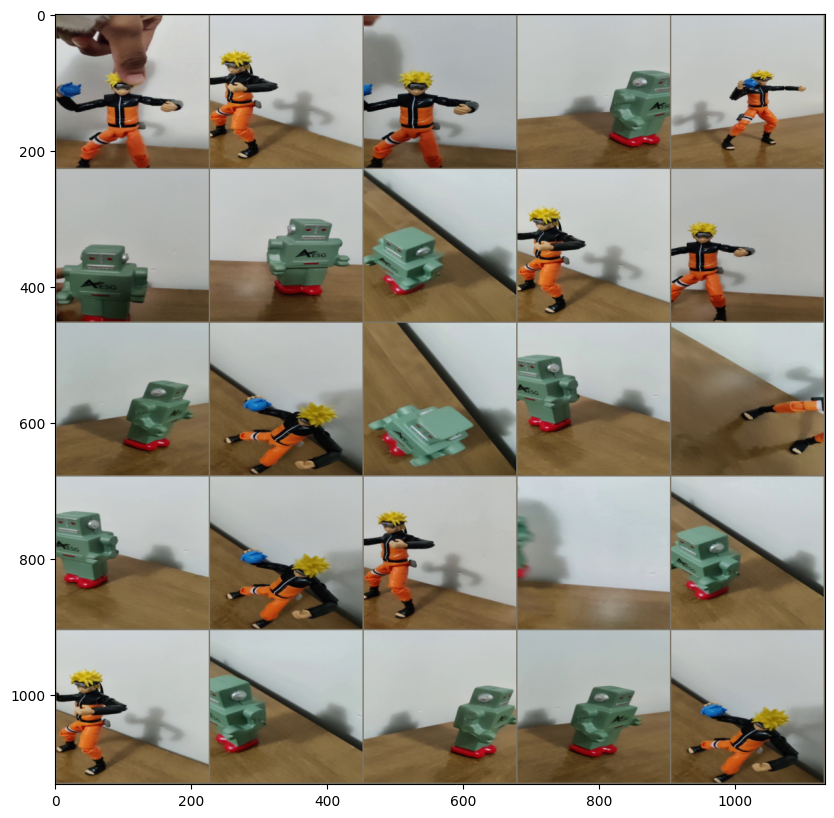

In [34]:
loader_ = DataLoader(total_dataset, batch_size=25, shuffle=True, num_workers=2)

def imshow(inp, title=None):
    
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs, classes = next(iter(loader_))

grid = torchvision.utils.make_grid(inputs, nrow=5)

imshow(grid)

## Putting labels on the frame

In [35]:
def add_label_on_frame(frame, label):

    position = (10,50)
    font_color = (255,255,255)

    labeled_frame = cv2.putText(
        frame, 
        text=label, 
        org=position, 
        fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
        fontScale=1, 
        color=font_color, 
        thickness=2, 
        lineType=cv2.LINE_AA
    )
    return labeled_frame

## Video Analysis

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# video_path = r"C:\Users\prakh\Desktop\testing\7_7_23\test_video2.mp4"
video_path = r"C:\Users\prakh\Desktop\testing\7_7_23\test_video4.mp4"

model = models.convnext_small(weights='DEFAULT')
model = torch.nn.Sequential(*list(model.children())[:-1])

model = model.to(device)
model.eval()

cap = cv2.VideoCapture(video_path)

fourcc = cv2.VideoWriter_fourcc(*'XVID')  # or use 'XVID' if MP4V doesn't work
out = cv2.VideoWriter('output_video.mp4', fourcc, 20.0, (720, 720))

while True:
    ret, frame = cap.read()

    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input_tensor = transform(pil_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        # features = torch.flatten(outputs, 1).cpu().numpy()
        outputs = model(input_tensor)                                       
        feature_vector = torch.flatten(outputs, 1).cpu().numpy()

    for method in methods:
        frame_copy = np.copy(frame)
        assigned_label = assign_label(feature_vector, method)
        labeled_frame = add_label_on_frame(frame_copy, assigned_label)
        labeled_frame = cv2.resize(labeled_frame, (720, 720))
        cv2.imshow(f'Object Detection', labeled_frame)
        # cv2.imshow(f'Object Detection - {method}', labeled_frame)
        out.write(labeled_frame)


    
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()


Can't receive frame (stream end?). Exiting ...
